## SIADS Milestone I: CFB Analysis

#### The goal of this notebook is to understand where the most talented recruits come from, and where they choose to go to school.

--
##### Notebook Outline:

1) Read in the teams dataset from the API (including the coordinates of the school).
2) Read in Recruit Dataset (where 1 row is one recruit)
3) Join on the School column
4) Create two datasets:
* One that shows where the recruit is from
* One that shows where the recruit went to school.
5) Create two maps showing distribution of talent: hometown vs school they committed to





In [1]:
# Uncomment and run line below if cfbd library isn't already installed
#! pip install cfbd

import cfbd
import numpy as np
import pandas as pd
import altair as alt
import cfbd

pd.set_option('display.max_columns', None)

#### Read in Teams dataset from API

In [2]:
# Get the teams dataset straight form the api
# The CSV version of the url was corrupted

import config
api_key = config.api_key

def api_setup(api_key):

    """
    Configure the api. 
    Only input is the apikey which can be created from the link above.
    """
    import cfbd
    
    configuration = cfbd.Configuration()
    configuration.api_key['Authorization'] = api_key
    configuration.api_key_prefix['Authorization'] = 'Bearer'

    return cfbd.ApiClient(configuration)
    
api_config = api_setup(api_key)

def team_dataset():

    teams_api = cfbd.TeamsApi(api_config)
    teams = teams_api.get_fbs_teams()

    df_teams = pd.DataFrame.from_records([t.to_dict() for t in teams])
    
    # Extract coordinates from dict columns
    df_teams['latitude_school'] = df_teams['location'].apply(lambda x: x.get('latitude'))
    df_teams['longitude_school'] = df_teams['location'].apply(lambda x: x.get('longitude'))
    
    df_teams = df_teams[['id', 'school', 'conference', 'division', 'color', 'logos', 'latitude_school', 'longitude_school']]
    
    return df_teams

df_teams = team_dataset()

# Remove brackets around image url
df_teams['logos'] = df_teams['logos'].str.get(0)

#### Read in recruit dataset

In [3]:
df_recruits = pd.read_csv('../data/recruits.csv')

#### Merge two datasets together based on the school the recruit went to

In [4]:
df_merged = pd.merge(left = df_recruits, right = df_teams, left_on = 'committed_to', right_on = 'school', how = 'inner')

col = ['year', 'ranking', 'name', 'committed_to', 'position', 'height', \
       'weight', 'stars', 'rating', 'latitude', 'longitude', 'state_province',\
       'school_y', 'conference', 'color', 'logos', 'latitude_school', 'longitude_school']

df_merged = df_merged[col]
df_merged['four_star_or_better'] = np.where(df_merged['stars'] >= 4, 1, 0) # Flag saying whether recruit is a 4 star

df_merged.head()

,year,ranking,name,committed_to,position,height,weight,stars,rating,latitude,longitude,state_province,school_y,conference,color,logos,latitude_school,longitude_school,four_star_or_better
0,2013,1.0,Robert Nkemdiche,Ole Miss,SDE,76.0,285.0,5,1.0000,33.838998,-83.900738,GA,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
1,2013,4.0,Laremy Tunsil,Ole Miss,OT,78.0,295.0,5,0.9975,30.189676,-82.639290,FL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
2,2013,14.0,Laquon Treadwell,Ole Miss,WR,75.0,195.0,5,0.9922,41.444533,-87.631383,IL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
3,2013,33.0,Tony Conner,Ole Miss,S,73.5,203.0,5,0.9841,34.311498,-89.944257,MS,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
4,2013,94.0,Austin Golson,Ole Miss,OT,78.0,285.0,4,0.9553,32.464025,-86.459697,AL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1


##### Create the two datasets showing recruits by where the went to school vs where they came from

In [5]:
# Aggregate by recruit home town coordinates
geo_df = df_merged.groupby(by = ['longitude', 'latitude']).agg({'name': 'count', 'four_star_or_better': 'sum', 'stars': 'sum'})\
                  .reset_index()\
                  .rename({'name': 'recruits',  'four_star_or_better': '4+ Star Recruits'}, axis = 1)
geo_df.head()

,longitude,latitude,recruits,4+ Star Recruits,stars
0,-170.704830,-14.275479,26,0,67
1,-162.356948,65.188685,1,0,3
2,-159.346352,22.083340,4,0,12
3,-158.185272,21.446678,4,1,12
4,-158.077849,21.334008,14,1,41


In [6]:
# Aggregate by the location of where the recruit went to school

geo_df_school = df_merged.groupby(by = ['longitude_school', 'latitude_school']).agg({'name': 'count', 'four_star_or_better': 'sum', 'stars':'sum'})\
    .reset_index()\
    .rename({'name': 'recruits', 'four_star_or_better': '4+ Star Recruits'}, axis = 1)
geo_df_school.head()

,longitude_school,latitude_school,recruits,4+ Star Recruits,stars
0,-157.819338,21.294294,153,0,388
1,-123.281434,44.559456,205,5,607
2,-123.068488,44.058271,244,116,847
3,-122.301575,47.650323,230,85,765
4,-122.250773,37.871043,207,20,634


#### Create Heatmaps from the two datasets above

In [7]:
# ! pip install plotly
import pandas as pd
import plotly.express as px

# Heatmatp of recruits by home town
fig = px.density_mapbox(geo_df, lat = 'latitude', lon = 'longitude', z = '4+ Star Recruits',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        range_color = [0, 100])
fig.write_html('recruit_home.html', auto_open=True)


# Heatmap of recruits by school of choice
fig = px.density_mapbox(geo_df_school, lat = 'latitude_school', lon = 'longitude_school', z = '4+ Star Recruits',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        range_color = [0, 100])
fig.write_html('recruit_school.html', auto_open=True)

#### Exploring paths...


#### Source: 
##### https://plotly.com/python/lines-on-maps/

In [8]:
df_merged.shape

(28259, 19)

In [9]:
df_merged.head()

,year,ranking,name,committed_to,position,height,weight,stars,rating,latitude,longitude,state_province,school_y,conference,color,logos,latitude_school,longitude_school,four_star_or_better
0,2013,1.0,Robert Nkemdiche,Ole Miss,SDE,76.0,285.0,5,1.0000,33.838998,-83.900738,GA,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
1,2013,4.0,Laremy Tunsil,Ole Miss,OT,78.0,295.0,5,0.9975,30.189676,-82.639290,FL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
2,2013,14.0,Laquon Treadwell,Ole Miss,WR,75.0,195.0,5,0.9922,41.444533,-87.631383,IL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
3,2013,33.0,Tony Conner,Ole Miss,S,73.5,203.0,5,0.9841,34.311498,-89.944257,MS,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1
4,2013,94.0,Austin Golson,Ole Miss,OT,78.0,285.0,4,0.9553,32.464025,-86.459697,AL,Ole Miss,SEC,#001148,http://a.espncdn.com/i/teamlogos/ncaa/500/145.png,34.361984,-89.534208,1


In [10]:
# Experiment by aggregating locations



In [11]:
df_teams['conference'].unique()

array(['Mountain West', 'Mid-American', 'SEC', 'Sun Belt', 'Pac-12',
       'FBS Independents', 'Big 12', 'ACC', 'American Athletic',
       'Conference USA', 'Big Ten'], dtype=object)

In [12]:
import plotly.graph_objects as go

def plot_recr_trail(year = 2019, team = 'Michigan'):
    fig = go.Figure()
    
    # df_path = df_merged.head(500).round(4)

    # year = 2022
    # team = 'Michigan'
    
    df_path = df_merged.round(1)
    df_path = df_path.groupby(by = ['latitude', 'longitude', 'latitude_school', 'longitude_school', 'committed_to', 'year', 'conference'])\
                     .agg({'rating': 'mean', 'name':'count'})\
                     .reset_index()

    df_path = df_path[df_path['year'] == year]
    # df_path = df_path[df_path['committed_to'] == team]
    df_path = df_path[df_path['conference'].isin(['SEC', 'Big Ten', 'ACC', 'Pac-12', 'Big 12'])]
    
    df_path = df_path.reset_index()
    
    flight_paths = []
    for i in range(len(df_path)):

    ###
        if df_path['conference'][i] == 'SEC':
            color_conf_code = 'red'
            
        elif df_path['conference'][i] == 'Big Ten':
            color_conf_code = 'blue'
            
        elif df_path['conference'][i] == 'ACC':
            color_conf_code = 'lightblue'
    
        elif df_path['conference'][i] == 'Pac-12':
            color_conf_code = 'green'
    
        elif df_path['conference'][i] == 'Big 12':
            color_conf_code = 'purple'
        
        else:
            color_conf_code = 'gray'
    ###

        
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [df_path['longitude'][i], df_path['longitude_school'][i]],
                lat = [df_path['latitude'][i], df_path['latitude_school'][i]],
                mode = 'lines',
                line = dict(width = 1, color = color_conf_code),
                #fillcolor = 'color',
                #color = 'conference',
                opacity = float(df_path['name'][i]) / float(df_path['name'].max()),
            )
        )
    
    fig.update_layout(
        title_text = 'Football Recruits Movement from Hometown to University',
        showlegend = False,
        # autosize = True,
        width = 1000,
        height = 600,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )

    # margin=dict(l=20, r=20, t=20, b=20)
    
    fig.show()
    # fig.write_html('recruit_lines.html', auto_open=True)

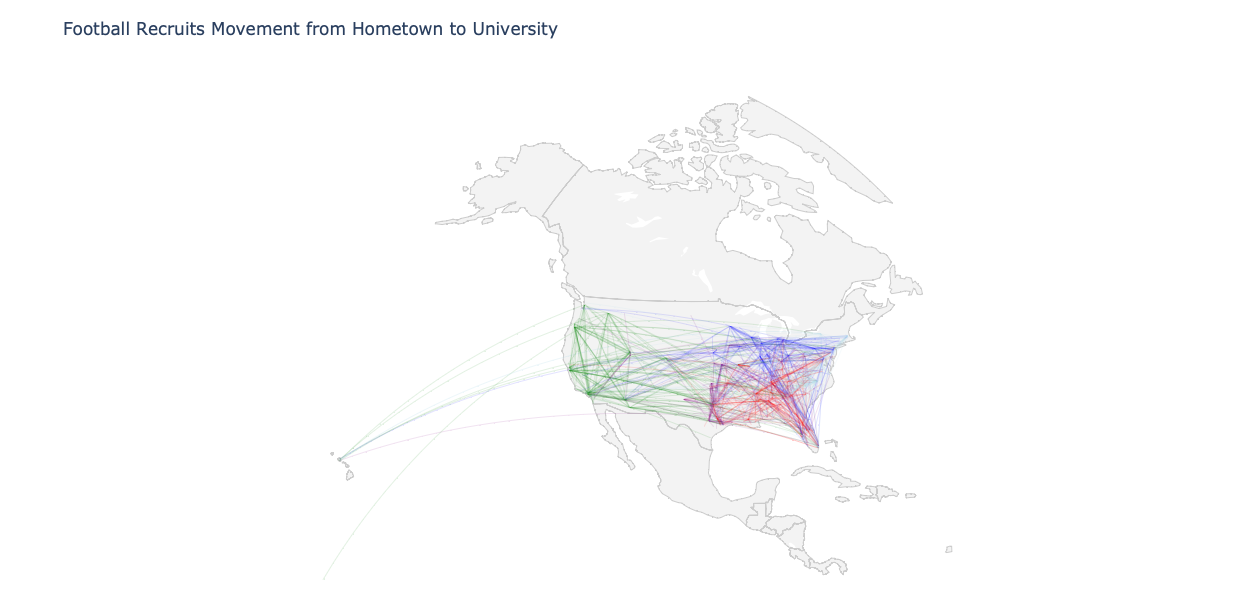

In [15]:
plot_recr_trail(2021, 'Georgia')

In [14]:
df_path = df_merged.round(1)
df_path = df_path.groupby(by = ['latitude', 'longitude', 'latitude_school', 'longitude_school', 'committed_to', 'year', 'conference'])\
                 .agg({'rating': 'mean', 'name':'count'})\
                 .reset_index()

df_path = df_path[df_path['year'] == year]
df_path = df_path[df_path['committed_to'].isin(teams)]

df_path = df_path.reset_index()

NameError: name 'year' is not defined

In [ ]:
import plotly.graph_objects as go

def plot_recr_team_trail(year = 2019, teams = ['Michigan']):
    fig = go.Figure()
    
    # df_path = df_merged.head(500).round(4)

    # year = 2022
    # team = 'Michigan'
    
    df_path = df_merged.round(1)
    df_path = df_path.groupby(by = ['latitude', 'longitude', 'latitude_school', 'longitude_school', 'committed_to', 'year', 'conference', 'color'])\
                     .agg({'rating': 'mean', 'name':'count'})\
                     .reset_index()

    df_path = df_path[df_path['year'] == year]
    df_path = df_path[df_path['committed_to'].isin(teams)]
    # df_path = df_path[df_path['conference'].isin(['SEC', 'Big Ten', 'ACC', 'Pac-12', 'Big 12'])]
    
    df_path = df_path.reset_index()
    
    flight_paths = []
    for i in range(len(df_path)):

        team_hex = df_path['color'][i]

        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [df_path['longitude'][i], df_path['longitude_school'][i]],
                lat = [df_path['latitude'][i], df_path['latitude_school'][i]],
                mode = 'lines',
                line = dict(width = 2, color = team_hex),
                #fillcolor = 'color',
                #color = 'conference',
                opacity = float(.80),
            )
        )
    
    fig.update_layout(
        title_text = 'Football Recruits Movement from Hometown to University. Color of line matches University they committed to',
        showlegend = False,
        # autosize = True,
        width = 1000,
        height = 600,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )

    # margin=dict(l=20, r=20, t=20, b=20)
    
    fig.show()
    # fig.write_html('recruit_lines.html', auto_open=True)

In [ ]:
teams = ['Michigan', 'USC', 'Rutgers']

plot_recr_team_trail(2019, teams)